<a href="https://colab.research.google.com/github/mayureshagashe2105/Noise-Suppression/blob/main/Noise_Suppression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import os
import glob
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import style
import zipfile
import pickle

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
if not os.path.exists('/content/Noise_Suprresion'):
  with zipfile.ZipFile('/content/gdrive/MyDrive/Noise supression Dataset/DS_10283_1942.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/Noise_Suprresion/unzipped_dataset')

  with zipfile.ZipFile('/content/Noise_Suprresion/unzipped_dataset/clean_trainset_wav.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/Noise_Suprresion/train/clean')

  with zipfile.ZipFile('/content/Noise_Suprresion/unzipped_dataset/noisy_trainset_wav.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/Noise_Suprresion/train/noisy')

  with zipfile.ZipFile('/content/Noise_Suprresion/unzipped_dataset/clean_testset_wav.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/Noise_Suprresion/test/clean')

  with zipfile.ZipFile('/content/Noise_Suprresion/unzipped_dataset/noisy_testset_wav.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/Noise_Suprresion/test/noisy')
  
  print('Files unzipped successfully!')

else:
  print('Files already exists!')

Files unzipped successfully!


In [3]:
clean_train_list = glob.glob('/content/Noise_Suprresion/train/clean/*')
noisy_train_list = glob.glob('/content/Noise_Suprresion/train/noisy/*')

In [4]:
clean_samples, _ = tf.audio.decode_wav(tf.io.read_file(clean_train_list[0]), desired_channels=1)
for audio in tqdm(clean_train_list[1:]):
  aud, _ = tf.audio.decode_wav(tf.io.read_file(audio), desired_channels=1)
  clean_samples = tf.concat([clean_samples, aud], axis=0)


noisy_samples, _ = tf.audio.decode_wav(tf.io.read_file(noisy_train_list[0]), desired_channels=1)
for audio in tqdm(noisy_train_list[1:]):
  aud, _ = tf.audio.decode_wav(tf.io.read_file(audio), desired_channels=1)
  noisy_samples = tf.concat([noisy_samples, aud], axis=0)

clean_samples, noisy_samples

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(<tf.Tensor: shape=(540938091, 1), dtype=float32, numpy=
 array([[-0.00186157],
        [-0.0038147 ],
        [-0.00354004],
        ...,
        [ 0.00460815],
        [ 0.00466919],
        [ 0.00473022]], dtype=float32)>,
 <tf.Tensor: shape=(540938091, 1), dtype=float32, numpy=
 array([[-0.01724243],
        [-0.02206421],
        [ 0.00415039],
        ...,
        [-0.00933838],
        [-0.00518799],
        [ 0.0065918 ]], dtype=float32)>)

In [5]:
with open('clean_samples.pkl', 'wb') as f:
  pickle.dump(clean_samples, f)
with open('noisy_samples.pkl', 'wb') as f:
  pickle.dump(noisy_samples, f)

In [3]:
pickle_in = open('clean_samples.pkl', 'rb')
clean_samples = pickle.load(pickle_in)
clean_samples = tf.cast(clean_samples, 'float16')

pickle_in = open('noisy_samples.pkl', 'rb')
noisy_samples = pickle.load(pickle_in)
noisy_samples = tf.cast(noisy_samples, 'float16')

In [4]:
clean_train, noisy_train = [], []
sampling_size = 16000
for i in range((noisy_samples.shape[0]) // sampling_size):
  clean_train.append(clean_samples[i * sampling_size:i * sampling_size + sampling_size])
  noisy_train.append(noisy_samples[i * sampling_size:i * sampling_size + sampling_size])

noisy_train = tf.stack(noisy_train)
clean_train = tf.stack(clean_train)

clean_train, noisy_train

(<tf.Tensor: shape=(33808, 16000, 1), dtype=float16, numpy=
 array([[[-1.8616e-03],
         [-3.8147e-03],
         [-3.5400e-03],
         ...,
         [ 5.4932e-04],
         [-1.2207e-04],
         [-4.2725e-04]],
 
        [[-1.4648e-03],
         [-2.0752e-03],
         [-3.1128e-03],
         ...,
         [-2.7563e-01],
         [-2.9297e-01],
         [-3.0786e-01]],
 
        [[-2.8955e-01],
         [-1.8652e-01],
         [-2.9877e-02],
         ...,
         [-7.0801e-03],
         [-7.5378e-03],
         [-7.3547e-03]],
 
        ...,
 
        [[-2.7161e-02],
         [-2.4536e-02],
         [-2.2186e-02],
         ...,
         [ 5.3711e-03],
         [ 2.5635e-03],
         [ 4.6997e-03]],
 
        [[ 6.6223e-03],
         [ 4.2419e-03],
         [ 1.8311e-03],
         ...,
         [ 5.3467e-02],
         [ 4.3335e-03],
         [-4.9408e-02]],
 
        [[-1.0516e-01],
         [-1.6016e-01],
         [-2.0850e-01],
         ...,
         [-1.3000e-02],
         [

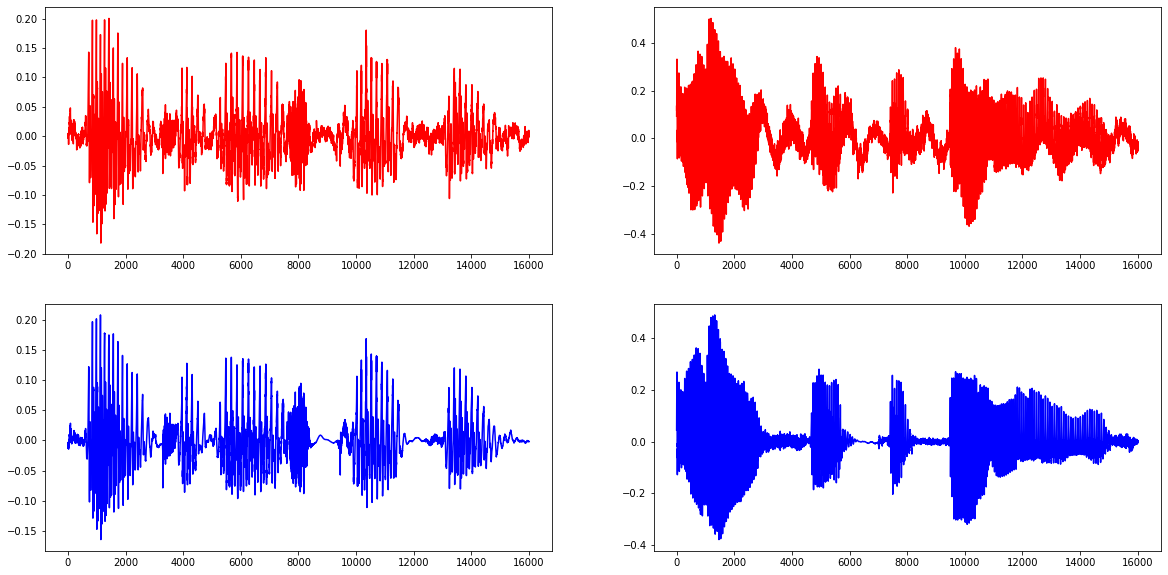

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0][0].plot(np.arange(noisy_train[10].shape[0]), noisy_train[10], color='r')
axes[1][0].plot(np.arange(clean_train[10].shape[0]), clean_train[10], color='b')

axes[0][1].plot(np.arange(noisy_train[100].shape[0]), noisy_train[100], color='r')
axes[1][1].plot(np.arange(clean_train[100].shape[0]), clean_train[100], color='b')

plt.show()

In [7]:
def input_pipeline(X, y, batch_size, shuffle_buffer, train_split=0.8):
  train_split_index = int(X.shape[0] * 0.8)
  ds = tf.data.Dataset.from_tensor_slices((X, y))
  ds = ds.shuffle(shuffle_buffer)
  train_ds, val_ds = ds.take(train_split_index), ds.skip(train_split_index)
  train_ds = train_ds.batch(batch_size)
  val_ds = val_ds.batch(batch_size)
  return train_ds.prefetch(1), val_ds.prefetch(1)

train_ds, val_ds = input_pipeline(noisy_train, clean_train, 64, 50000)
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 16000, 1), (None, 16000, 1)), types: (tf.float16, tf.float16)>,
 <PrefetchDataset shapes: ((None, 16000, 1), (None, 16000, 1)), types: (tf.float16, tf.float16)>)

In [30]:
def build_model():
  inputs = layers.Input((16000, 1))

  conv1 = layers.Conv1D(2, 32, 2, padding='same', activation='relu')(inputs)
  conv2 = layers.Conv1D(4, 32, 2, padding='same', activation='relu')(conv1)
  conv3 = layers.Conv1D(8, 32, 2, padding='same', activation='relu')(conv2)
  conv4 = layers.Conv1D(16, 32, 2, padding='same', activation='relu')(conv3)
  conv5 = layers.Conv1D(32, 32, 2, padding='same', activation='relu')(conv4)

  deconv1 = layers.Conv1DTranspose(32, 32, 1, padding='same')(conv5)
  concat = layers.Concatenate()([conv5, deconv1])
  deconv2 = layers.Conv1DTranspose(16, 32, 2, padding='same')(concat)
  concat = layers.Concatenate()([conv4, deconv2])
  deconv3 = layers.Conv1DTranspose(8, 32, 2, padding='same')(concat)
  concat = layers.Concatenate()([conv3, deconv3])
  deconv4 = layers.Conv1DTranspose(4, 32, 2, padding='same')(concat)
  concat = layers.Concatenate()([conv2, deconv4])
  deconv5 = layers.Conv1DTranspose(2, 32, 2, padding='same')(concat)
  concat = layers.Concatenate()([conv1, deconv5])
  deconv6 = layers.Conv1DTranspose(1, 32, 2, padding='same')(concat)
  concat = layers.Concatenate()([inputs, deconv6])
  deconv6 = layers.Conv1DTranspose(1, 32, 1, padding='same', activation='linear')(concat)



  model = tf.keras.Model(inputs=[inputs], outputs=[deconv6], name='auto_encoders_for_noise_removal')

  return model

model = build_model()
print(model.summary())

Model: "auto_encoders_for_noise_removal"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 16000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 8000, 2)      66          input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 4000, 4)      260         conv1d_55[0][0]                  
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 2000, 8)      1032        conv1d_56[0][0]                  
____________________________________________________________________

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.Huber(),
              metrics='mae')  

In [32]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch / 20))

In [33]:
history = model.fit(train_ds, callbacks=[lr_scheduler], epochs=100)

Epoch 1/100
423/423 [==============================] - 42s 95ms/step - loss: 0.0034 - mae: 0.0531
Epoch 2/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0033 - mae: 0.0524
Epoch 3/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0033 - mae: 0.0519
Epoch 4/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0032 - mae: 0.0510
Epoch 5/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0030 - mae: 0.0500
Epoch 6/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0029 - mae: 0.0486
Epoch 7/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0027 - mae: 0.0465
Epoch 8/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0023 - mae: 0.0432
Epoch 9/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0018 - mae: 0.0382
Epoch 10/100
423/423 [==============================] - 40s 94ms/step - loss: 0.0015 - mae: 0.0351
Epoch 11/100
423/42

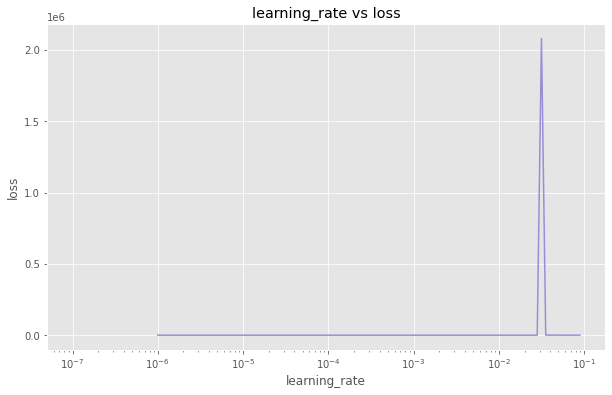

In [35]:
style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.semilogx(1e-7, 1, 0, 1)
plt.plot(history.history['lr'], history.history['loss'])
plt.title('learning_rate vs loss')
plt.xlabel('learning_rate')
plt.ylabel('loss')
plt.show()

In [39]:
model = build_model()

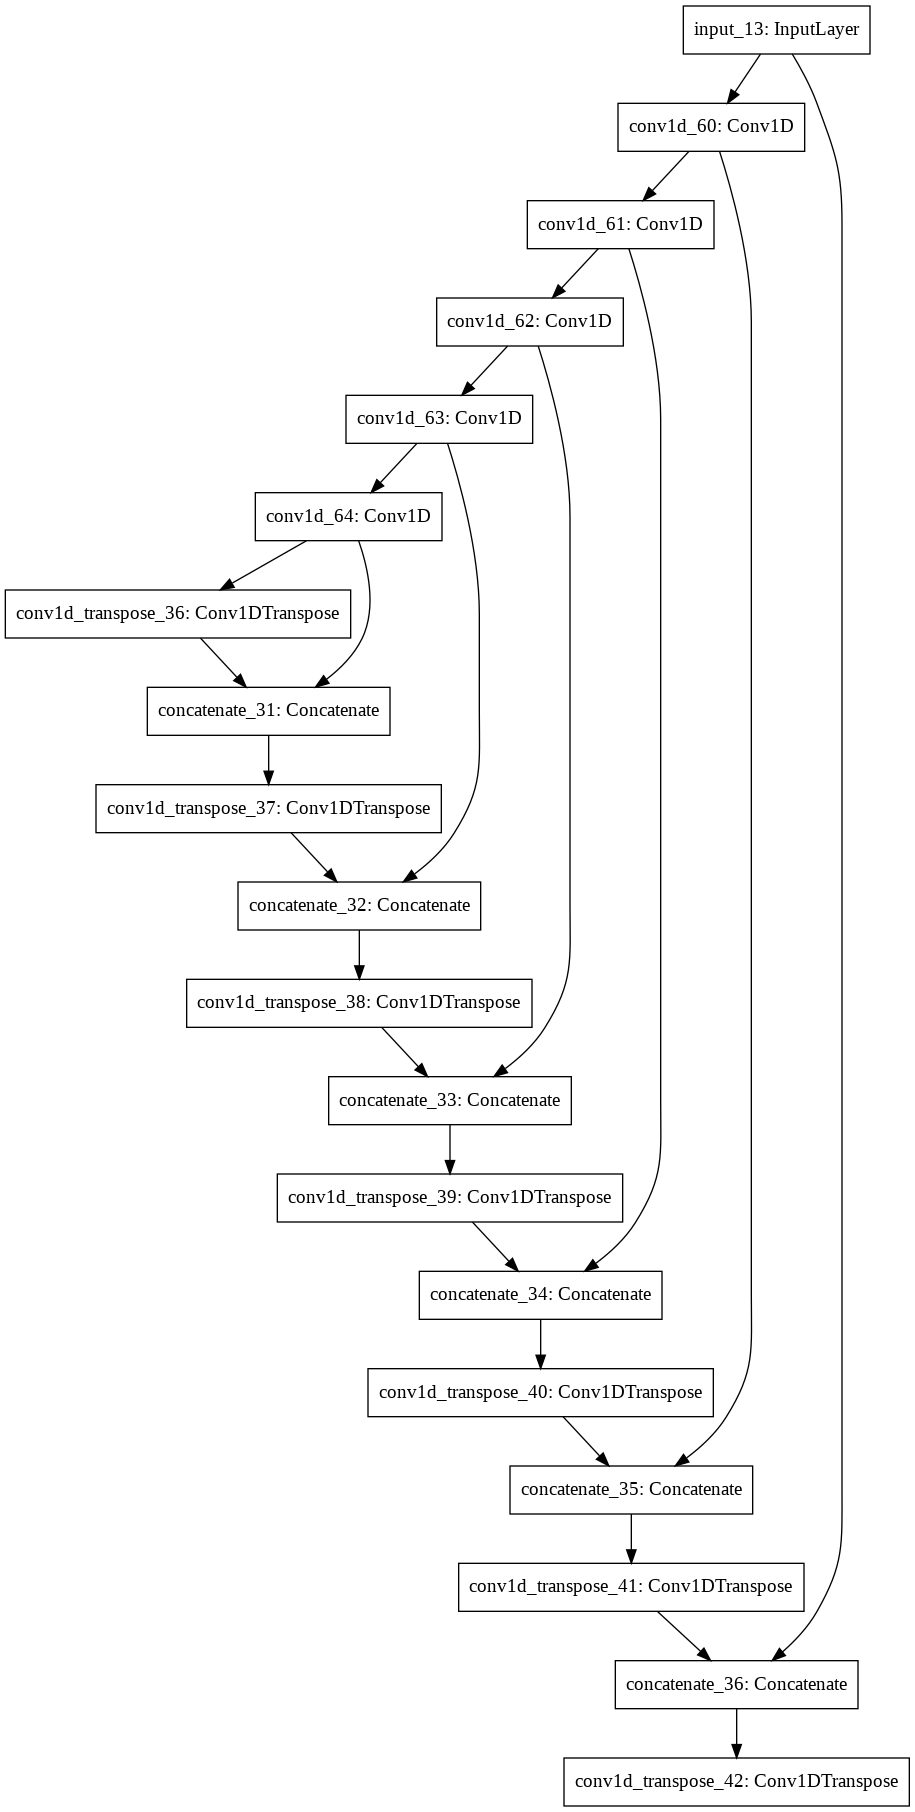

In [37]:
tf.keras.utils.plot_model(model, 'auto_encoders_for_noise_removal.png')

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0023),
              loss=tf.keras.losses.Huber(),
              metrics='mae')  

In [41]:
history = model.fit(train_ds, epochs=20)

Epoch 1/20
423/423 [==============================] - 42s 94ms/step - loss: 5.3746e-04 - mae: 0.0203
Epoch 2/20
423/423 [==============================] - 40s 94ms/step - loss: 3.0889e-04 - mae: 0.0157
Epoch 3/20
423/423 [==============================] - 40s 94ms/step - loss: 2.6621e-04 - mae: 0.0145
Epoch 4/20
423/423 [==============================] - 40s 94ms/step - loss: 2.4342e-04 - mae: 0.0138
Epoch 5/20
423/423 [==============================] - 40s 94ms/step - loss: 2.2875e-04 - mae: 0.0133
Epoch 6/20
423/423 [==============================] - 40s 94ms/step - loss: 2.2118e-04 - mae: 0.0131
Epoch 7/20
423/423 [==============================] - 40s 94ms/step - loss: 2.1604e-04 - mae: 0.0129
Epoch 8/20
423/423 [==============================] - 40s 94ms/step - loss: 2.0995e-04 - mae: 0.0127
Epoch 9/20
423/423 [==============================] - 40s 94ms/step - loss: 2.0738e-04 - mae: 0.0126
Epoch 10/20
423/423 [==============================] - 40s 94ms/step - loss: 2.0535e-04 - m

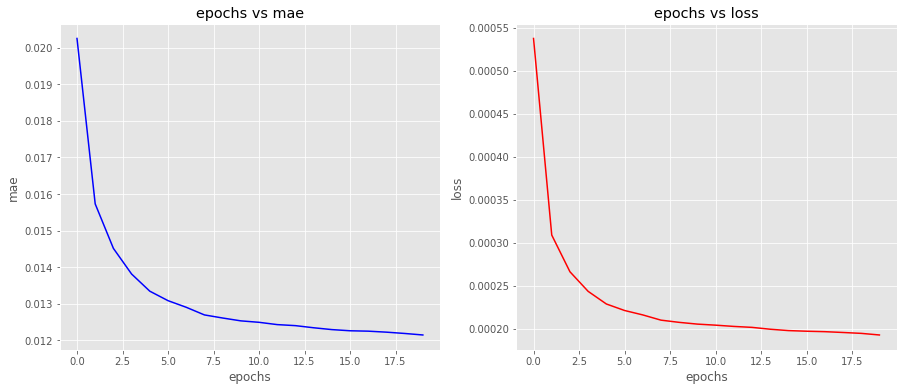

In [51]:
epochs = np.arange(len(history.history['loss']))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(epochs, history.history['mae'], color='b')
axes[0].set_title('epochs vs mae')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('mae')


axes[1].plot(epochs, history.history['loss'], color='r')
axes[1].set_title('epochs vs loss')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')

plt.show()

In [42]:
model.save('auto_encoders_for_noise_removal.h5')

In [43]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[22].numpy()),rate=16000)

In [44]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[22],-1),0))),rate=16000)

In [45]:
model.evaluate(val_ds)   

106/106 [==============================] - 7s 42ms/step - loss: 1.9169e-04 - mae: 0.0121


[0.00019169217557646334, 0.012121148407459259]